In [0]:
notebook_path = "Projects/QuantumFlow/notebooks"
try:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)
except:
    pass

%tensorflow_version 2.x
!pip install -q ruamel.yaml
!pip install -q tensorflow-addons

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('../')

from quantumflow.colab_utils import load_hyperparameters, test_colab_devices, get_resolver, QFDataset

has_gpu, has_tpu = test_colab_devices()
if has_gpu: print("Found GPU")
if has_tpu: print("Found TPU")

data_dir = "../data"
%load_ext tensorboard

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
TensorFlow 2.x selected.


In [0]:
data_dir = "../data"
experiment = 'ke_cnn'
run_name = 'test'

preview = 5
figsize = (20, 3)
dpi = None
kcalmol_per_hartree = 627.51

base_dir = os.path.join(data_dir, experiment)
log_dir = "gs://quantumflow/" + experiment if has_tpu else '/home/' + experiment
file_hyperparams = os.path.join(base_dir, "hyperparams (1).config")

params = load_hyperparameters(file_hyperparams, run_name=run_name)
export_dir = os.path.join(base_dir, run_name, 'saved_model')

model = tf.saved_model.load(export_dir)

dataset_train = QFDataset(os.path.join(data_dir, params['dataset_train'] + '.pkl'), params)
dataset_eval = QFDataset(os.path.join(data_dir, params['dataset_validate'] + '.pkl'), params)

dataset_test = QFDataset(os.path.join(data_dir,  'recreate/dataset_test.pkl'), params)
dataset_sample = QFDataset(os.path.join(data_dir, 'recreate/dataset_sample.pkl'), params)

In [0]:
%tensorboard --logdir $base_dir

In [0]:
def plot_prediction_analysis(kinetic_energy, derivative, dataset):
    
    kenergies_err = np.abs(dataset.kinetic_energy - kinetic_energy)*kcalmol_per_hartree
    derivative_err = np.max(np.abs(dataset.derivative - derivative), axis=1)

    print('MAE:', np.mean(kenergies_err))
    print('AE_std:', np.std(kenergies_err))
    print('AE_max:', np.max(kenergies_err))

    plt.figure(figsize=(20, 4))
    plt.hist(kenergies_err, bins=100)
    plt.title('Kinetic Energy Absolute Error')
    plt.xlabel('kcal/mol')
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.hist(derivative_err, bins=100)
    plt.title('Functional Derivative Max Absolute Error')
    plt.xlabel('hartree')
    plt.show()


MAE: 0.6183489
AE_std: 2.8166857
AE_max: 143.79889


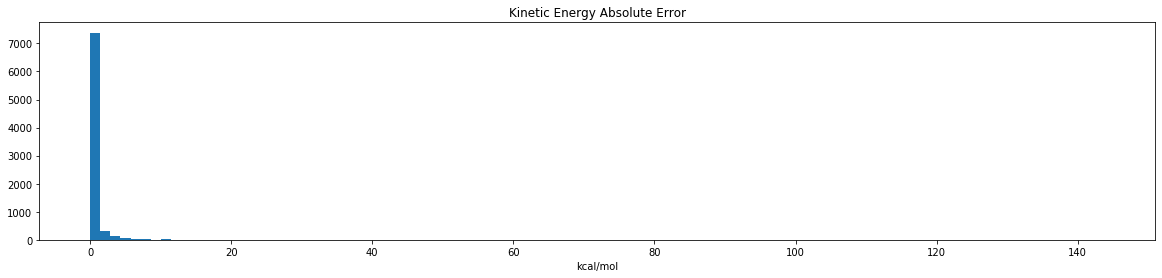

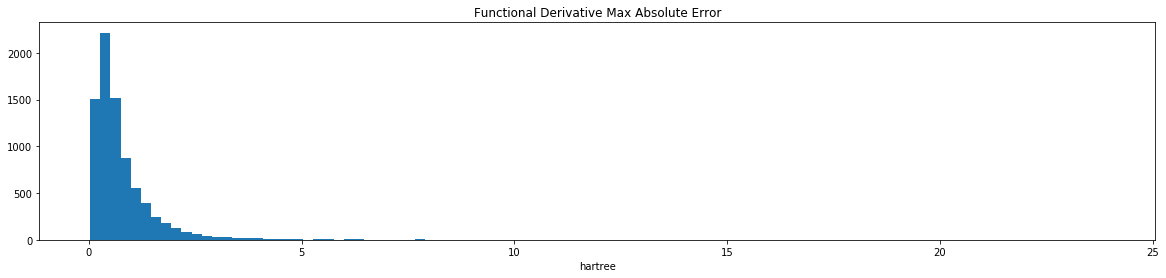

Energy prediction:
6.3905015 6.1613436  = 143.79888929843904 kcal/mol


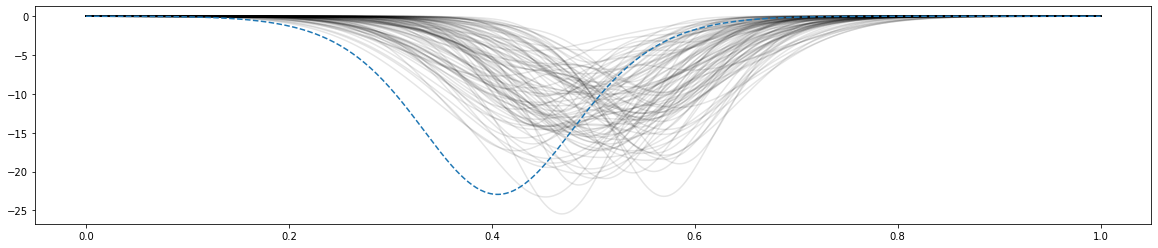

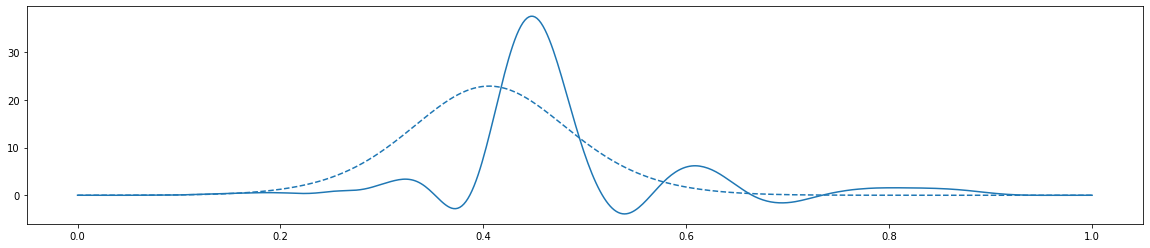

In [0]:
predictions = model({'density': dataset_test.density})
plot_prediction_analysis(predictions['kinetic_energy'], predictions['derivative'], dataset_test)

indices = np.argsort(np.abs(predictions['kinetic_energy'] - dataset_test.kinetic_energy), axis=0)
largest_error = indices[-1]

print('Energy prediction:')
print(dataset_test.kinetic_energy[largest_error], predictions['kinetic_energy'].numpy()[largest_error], " =", 
      np.abs(dataset_test.kinetic_energy[largest_error] - predictions['kinetic_energy'][largest_error])*kcalmol_per_hartree, "kcal/mol")

plt.figure(figsize=(20, 4))
plt.plot(dataset_sample.x, dataset_train.potential.transpose(), 'k', alpha=0.1)
plt.plot(dataset_sample.x, dataset_test.potential[largest_error], 'C0', linestyle='--')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(dataset_sample.x, dataset_test.derivative[largest_error], 'C0', linestyle='--')
plt.plot(dataset_sample.x, predictions['derivative'][largest_error])
plt.show()

Energy prediction:
5.719325 tf.Tensor(5.7188797, shape=(), dtype=float32)  = 0.2794715595245361 kcal/mol


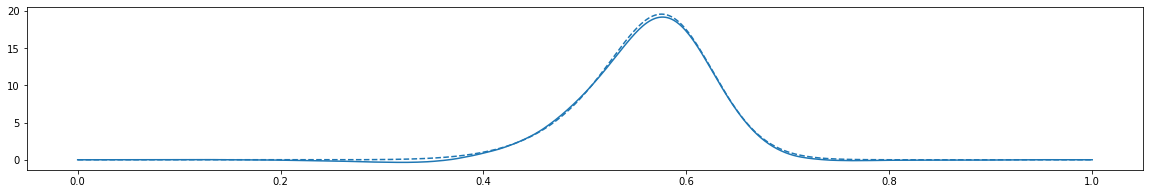

In [0]:
with tf.GradientTape() as tape:
    predictions = model({'density': dataset_sample.density})
variables = {variable.name:variable.numpy() for variable in tape.watched_variables()}

kinetic_energy_sample = predictions['kinetic_energy']
derivative_sample = predictions['derivative']

print('Energy prediction:')
print(dataset_sample.kinetic_energy[0], kinetic_energy_sample[0], " =", np.abs(dataset_sample.kinetic_energy[0]-kinetic_energy_sample[0])*kcalmol_per_hartree, "kcal/mol")

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(dataset_sample.x, dataset_sample.derivative[0], 'C0', linestyle='--')
plt.plot(dataset_sample.x, derivative_sample[0])
plt.show()

In [0]:
l = 0
for name, value in variables.items():
    if 'kernel' not in name or 'conv1d' not in name:
        continue
    
    fig, axs = plt.subplots(value.shape[2], 1, figsize=(figsize[0], 3 + value.shape[2]), dpi=dpi)
    if value.shape[2] == 1:
        axs = [axs]
        
    limit = np.max(np.abs(value))*1.1
    
    for i, kern in enumerate(np.moveaxis(value, 2, 0)):
        axs[i].plot(np.arange(len(kern[:, 0]))+1, kern, '.-', markersize=2, linewidth=0.5)
        axs[i].plot([1, len(kern)], [0, 0], 'k', linewidth=0.5, zorder=-3)
        axs[i].text(6, limit*0.6, 'bias: ' + str(variables[name.replace('kernel', 'bias')][i]))
        axs[i].set_ylabel('ch{} out '.format('.' if value.shape[2] > 6 else 'annel') + str(i+1))
        axs[i].set_ylim([-limit, limit])
        axs[i].set_xlim([1, len(kern)])
        
        if i == value.shape[2]-1: 
            axs[i].set_xlabel('index')
            axs[i].legend(['channel in ' + str(j+1) for j in range(kern.shape[1])], 
                          bbox_to_anchor=[1.0, 0.0], loc='lower right')
        else:
            axs[i].get_xaxis().set_visible(False)
        
        if i == 0:
            axs[i].set_title('layer {}: kernel_size: {}, filters: {}, activation: {}, padding: {}'.format(
            l, value.shape[0], value.shape[2], 'softplus' if l != 3 else 'sum', 'valid'), fontsize=10)
    l += 1

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print([v.name for v in variables])

#fig, axs = plt.subplots(value.shape[3], 1, figsize=(6, 2 + value.shape[3]), dpi=200)
fig, axs = plt.subplots(len(layers), 1, figsize=(15, len(layers)*2))

for i, layer in enumerate(layers):
        
    length = layer.shape[0]
    cutoff = (G - length)//2
    cutoffset = (G - length) % 2
    
    limit = np.max(np.abs(layer))*1.1

    axs[i].plot(np.arange(G-cutoff*2-cutoffset)+1, layer)#, '.-', markersize=2, linewidth=0.5)
    axs[i].set_ylim(-limit/10, limit)
    axs[i].set_xlim([-cutoff+1, G-cutoff])
    axs[i].grid(which='major', axis='y', linestyle='--')
    axs[i].set_xticks([1, length])
    
    axs[i].set_ylabel((i != len(layers)-1)*('layer ' + str(i)) + ' output' if i > 0 else 'input')
    if len(layer.shape) > 1:
        axs[i].legend(['channel ' + str(j+1) if j < 4 else '...' for j in range(layer.shape[1])][:5], loc='upper left')

AttributeError: ignored

In [0]:
trainable_variables = {id(v) for v in model.variables}
print(trainable_variables)

AttributeError: ignored

In [0]:
dataset_sample = QFDataset(os.path.join(data_dir, 'recreate/dataset_sample.pkl'), params)

predictions_n = {key:[] for key in params['targets']}

@tf.function
def sample_step(batch):
    features, targets = batch

    predictions = model(features)
    loss, losses = calc_loss(model, targets, predictions)
    
    return predictions, losses
    

In [0]:
anim_plot(np.stack([predictions_n['derivative'], np.repeat(dataset_sample.derivative, len(predictions_n['derivative']), axis=0)], axis=2)[::100], dataset_sample.x, interval=10, figsize=(15, 3))

## Scalars

In [0]:
def load_summaries(event_dir):
    import pandas as pd

    event_files = [os.path.join(event_dir, file) for file in os.listdir(event_dir) if '.tfevents' in file]

    values = {'wall_time': ([], [])}

    for raw_record in tf.data.TFRecordDataset(event_files):
        print(raw_record)
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

        continue
        if summary.summary.value.__len__() == 0: continue      

        if summary.step not in values['wall_time'][0]:
            values['wall_time'][0].append(summary.step)
            values['wall_time'][1].append(summary.wall_time)

        for entry in summary.summary.value:
            try:
                if summary.step not in values[entry.tag][0]:
                    values[entry.tag][0].append(summary.step)
                    values[entry.tag][1].append(entry.simple_value)

            except KeyError:
                values[entry.tag] = ([summary.step], [entry.simple_value])
                    
    for key in values.keys():        
        values[key] = pd.DataFrame(values[key][1], index=values[key][0], columns=[key])
    return values

In [0]:
summary_train = load_summaries(os.path.join(data_dir, experiment, run_name))
summary_eval = load_summaries(os.path.join(data_dir, experiment, run_name, 'eval'))
print(summary_train.keys(), summary_eval.keys())

In [0]:
plt.figure(figsize=(20, 4))
plt.plot(np.log10(summary_train['loss']))
plt.plot(np.log10(summary_train['loss'].ewm(com=10).mean()))
plt.plot(np.log10(summary_eval['loss']))
plt.show()

print(summary_train['global_step/sec'].mean()[0], 'global_step/sec')
print(summary_train['examples/sec'].mean()[0], 'examples/sec')

In [0]:
summary_train_ens = [load_summaries(os.path.join(data_dir, experiment, run_name)) for run_name in ensemble_run_names]
summary_eval_ens = [load_summaries(os.path.join(data_dir, experiment, run_name, 'eval')) for run_name in ensemble_run_names]

In [0]:
plt.figure(figsize=(20, 5))
for i, summary_e in enumerate(summary_train_ens): 
    plt.plot(summary_e['loss'].ewm(com=20).mean(), 'C' + str(i))
for i, summary_e in enumerate(summary_eval_ens): 
    plt.plot(summary_e['loss'], '--C' + str(i))

plt.yscale('log')
plt.ylim([10**(-4.5), 10**-2])
plt.xlim([0, 1000000])
plt.legend([name.replace('_', ': ') for name in ensemble_run_names] + [name.replace('_', ': ') + ', eval' for name in ensemble_run_names], ncol=2)
plt.grid()
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

In [0]:
plt.figure(figsize=(20, 4))
for i, summary_e in enumerate(summary_eval_ens): 
    plt.plot(summary_e['value_mae']*kcalmol_per_hartree, '--C' + str(i))

#plt.yscale('log')
plt.ylim([0, 6])
plt.xlim([0, 1000000])
plt.legend([name.replace('_', ': ') + ', eval' for name in ensemble_run_names])
plt.grid()
plt.xlabel('training step')
plt.ylabel('kinetic energy: mean absolute error / kcal/mol')
plt.show()




plt.figure(figsize=(20, 4))
for i, summary_e in enumerate(summary_eval_ens): 
    plt.plot(summary_e['derivative_mae'], '--C' + str(i))

plt.xlim([0, 1000000])
plt.legend([name.replace('_', ': ') + ', eval' for name in ensemble_run_names])
plt.grid()
plt.xlabel('training step')
plt.ylabel('derivative: mean absolute error / hartree')
plt.show()